In [287]:
from __future__ import print_function, division

import os
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import pandas as pd
import matplotlib.pyplot as plt

import time
import copy
import shutil
import re

#Mounting Google drive for Colab execution

from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

your_module = drive.CreateFile({'id':'1dBH4qAfLeP5AUbIlLZunJqcBzQ2BOUFF'})
your_module.GetContentFile('util.py')

from util import plot_confusion_matrix

torch.manual_seed(0)
# Define train and test directories
base_dir = '/content/drive/My Drive/dataset/places/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Pre-processing the dataset
# Normalize the images
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# Resize the images
resize = transforms.Resize((224, 224))

transforms = {
'train': transforms.Compose([
        resize,
        transforms.ToTensor(),
        normalize
]), 
'test': transforms.Compose([
        resize,
        transforms.ToTensor(),
        normalize
]),
}

# Dataset augmentation is not performed on the training images therefore the transform can be common

# Normalize the test set same as training set No need to perform augmentation
#transform_test = transforms.Compose([
#    resize,
#    transforms.ToTensor(),
#    normalize,
#])

In [255]:
# Applying the transforms to the datasets
# trainset = datasets.ImageFolder( os.path.join( base_dir, 'train') , transform_images)
# trainloader = torch.utils.data.DataLoader( trainset , batch_size = 4, shuffle = True, num_workers = 4)
# The shuffle is set to true for the taining images
# testset = datasets.ImageFolder( os.path.join( base_dir, 'test') , transform_images)
# testloader = torch.utils.data.DataLoader( testset , batch_size = 4, shuffle = True, num_workers = 4)

# Use the image folder function to create datasets
dataset = { x: datasets.ImageFolder( os.path.join( base_dir, x ), transforms[x] )for x in ['train', 'test']}

dataloader = { x: torch.utils.data.DataLoader( dataset[x], batch_size = 4, shuffle = True, num_workers = 4) for x in ['train', 'test']}

# Defining the classes
dataset_sizes = { x: len(dataset[x]) for x in ['train', 'test']}
class_names = dataset['train'].classes


print(class_names)

# Number of classes in the dataset
num_classes = 9

# Number of epochs to train for
# num_epochs = 2

['abbey', 'airport_terminal', 'alley', 'amphitheater', 'amusement_park', 'aquarium', 'aqueduct', 'arch', 'art_gallery']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


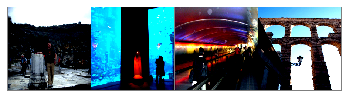

amphitheater - aquarium - airport_terminal - aqueduct


In [256]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(dataloader['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' - '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [257]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [258]:
alexnet = torchvision.models.alexnet(pretrained = True)

#for name, child in alexnet.named_children():
#  print(child)
#  print(name)

alexnet.classifier[6] = nn.Linear(4096,num_classes)
input_size = 224

model = alexnet.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.6)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    flag = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                if flag == 1:
                  scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()
                flag = 1
                # Time to carry out the forward training pass
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def predict_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/24
----------
Iterating through data...
train Loss: 1.2365 Acc: 0.5896
Iterating through data...
test Loss: 0.9926 Acc: 0.6812

Epoch 1/24
----------
Iterating through data...
train Loss: 0.6645 Acc: 0.7646
Iterating through data...
test Loss: 0.8742 Acc: 0.7302

Epoch 2/24
----------
Iterating through data...
train Loss: 0.3935 Acc: 0.8632
Iterating through data...
test Loss: 0.9982 Acc: 0.6921

Epoch 3/24
----------
Iterating through data...
train Loss: 0.1719 Acc: 0.9500
Iterating through data...
test Loss: 0.8898 Acc: 0.7493

Epoch 4/24
----------
Iterating through data...
train Loss: 0.1091 Acc: 0.9722
Iterating through data...
test Loss: 0.8892 Acc: 0.7493

Epoch 5/24
----------
Iterating through data...
train Loss: 0.0851 Acc: 0.9799
Iterating through data...
test Loss: 0.9326 Acc: 0.7657

Epoch 6/24
----------
Iterating through data...
train Loss: 0.0783 Acc: 0.9840
Iterating through data...
test Loss: 0.9308 Acc: 0.7657

Epoch 7/24
----------
Iterating through data...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


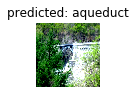

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


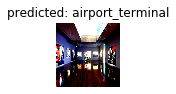

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


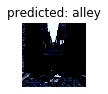

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


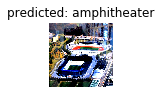

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


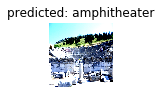

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


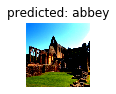

In [262]:
base_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, 25)
predict_model(base_model)
plt.show()

In [0]:
model_save_name = 'finemodel.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(base_model.state_dict(), path)

In [295]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        # print(classes)
        outputs = base_model(inputs)
        _, preds = torch.max(outputs, 1)
        # print(preds)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
cm = confusion_matrix.cpu().numpy()
df = pd.DataFrame(cm, index = class_names, columns = class_names)
plt.savefig('conf_finetune.png')
df.style.background_gradient(cmap='Blues')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation = 'vertical')
plt.show()

tensor([[30.,  0.,  3.,  4.,  0.,  0.,  0.,  3.,  0.],
        [ 0., 33.,  2.,  1.,  1.,  1.,  0.,  0.,  3.],
        [ 0.,  2., 35.,  0.,  2.,  0.,  0.,  2.,  0.],
        [ 2.,  0.,  0., 31.,  3.,  1.,  2.,  1.,  1.],
        [ 0.,  3.,  2.,  2., 32.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 40.,  0.,  0.,  1.],
        [ 5.,  1.,  1.,  1.,  6.,  0., 23.,  4.,  0.],
        [ 4.,  3.,  3.,  5.,  0.,  0.,  2., 22.,  2.],
        [ 0.,  5.,  0.,  0.,  0.,  1.,  0.,  0., 35.]])


,abbey,airport_terminal,alley,amphitheater,amusement_park,aquarium,aqueduct,arch,art_gallery
abbey,30,0,3,4,0,0,0,3,0
airport_terminal,0,33,2,1,1,1,0,0,3
alley,0,2,35,0,2,0,0,2,0
amphitheater,2,0,0,31,3,1,2,1,1
amusement_park,0,3,2,2,32,0,1,0,0
aquarium,0,0,0,0,0,40,0,0,1
aqueduct,5,1,1,1,6,0,23,4,0
arch,4,3,3,5,0,0,2,22,2
art_gallery,0,5,0,0,0,1,0,0,35


<Figure size 432x288 with 0 Axes>